### SegNet For Denoising

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
learning_rate = 1e-3
batch_size = 32
training_epochs = 500

In [3]:
filename = 'splitted_dataset.npz'
dataset = np.load(filename)
dataset.files

['inputs_train',
 'labels_train',
 'cleans_train',
 'inputs_test',
 'labels_test',
 'cleans_test']

In [4]:
inputs_train = dataset['inputs_train']
inputs_test  = dataset['inputs_test']
cleans_train = dataset['cleans_train']
cleans_test  = dataset['cleans_test']

In [5]:
class AutoEncoder_dataset(Dataset):
    def __init__(self, inputs, cleans):
        self.inputs = torch.from_numpy(inputs).float()
        self.cleans = torch.from_numpy(cleans).float()
    
    def __getitem__(self, index):
        inputs = self.inputs[index]
        cleans = self.cleans[index]
        return inputs, cleans
    
    def __len__(self):
        return len(self.inputs)

In [6]:
train_set = AutoEncoder_dataset(inputs = inputs_train,
                                cleans = cleans_train)
test_set  = AutoEncoder_dataset(inputs = inputs_test,
                                cleans = cleans_test)

In [7]:
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)
test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=False,
                         drop_last=False)

In [8]:
class SegNet(nn.Module):
    
    def __init__(self):
        super(SegNet, self).__init__()
        
        # Encoder
        
        self.Enc_0_1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_2_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_2_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels= 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_3_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels= 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_3_2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels= 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_4_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels= 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_4_2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels= 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Decoder
        
        self.Dec_4_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_4_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_3_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_3_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_2_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_2_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_1_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_0_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=2),
            nn.ReLU(inplace=True)
        )
        
        self.Unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
        
    def forward(self, inputs):
        
        # Encoder
        
        dim_0 = inputs.size()
        outputs = self.Enc_0_1(inputs)
        outputs, indice_0 = self.Pool(outputs)
        
        dim_1 = outputs.size()
        outputs = self.Enc_1_1(outputs)
        outputs, indice_1 = self.Pool(outputs)
        
        dim_2 = outputs.size()
        outputs = self.Enc_2_1(outputs)
        outputs = self.Enc_2_2(outputs)
        outputs, indice_2 = self.Pool(outputs)
        
        dim_3 = outputs.size()
        outputs = self.Enc_3_1(outputs)
        outputs = self.Enc_3_2(outputs)
        outputs, indice_3 = self.Pool(outputs)
        
        dim_4 = outputs.size()
        outputs = self.Enc_4_1(outputs)
        outputs = self.Enc_4_2(outputs)
        outputs, indice_4 = self.Pool(outputs)
        
        dim_middle = outputs.size()
        
        # Decoder
        outputs = self.Unpool(outputs, indice_4, output_size=dim_4)
        outputs = self.Dec_4_2(outputs)
        outputs = self.Dec_4_1(outputs)
        dim_4d = outputs.size()
        
        outputs = self.Unpool(outputs, indice_3, output_size=dim_3)
        outputs = self.Dec_3_2(outputs)
        outputs = self.Dec_3_1(outputs)
        dim_3d = outputs.size()
        
        outputs = self.Unpool(outputs, indice_2, output_size=dim_2)
        outputs = self.Dec_2_2(outputs)
        outputs = self.Dec_2_1(outputs)
        dim_2d = outputs.size()
        
        outputs = self.Unpool(outputs, indice_1, output_size=dim_1)
        outputs = self.Dec_1_1(outputs)
        dim_1d = outputs.size()
        
        outputs = self.Unpool(outputs, indice_0, output_size=dim_0)
        outputs = self.Dec_0_1(outputs)
        dim_0d = outputs.size()
        
        return outputs
        

In [9]:
GPU_NUM = 6
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print('Currernt cuda device ', torch.cuda.current_device())

if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Currernt cuda device  6
GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [10]:
net = SegNet().to(device)

In [11]:
criterion = nn.MSELoss()

In [12]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [13]:
total_batch = len(train_loader)


for epoch in range(training_epochs):
    avg_cost = 0

    for i, (inputs, cleans) in enumerate(train_loader):
        inputs = inputs.to(device)
        cleans = cleans.to(device)

        optimizer.zero_grad()
        hypothesis = net(inputs)
        cost = criterion(hypothesis, cleans)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    
    print('[Epoch : {:>4}] '.format(epoch + 1))
    print('cost = {:>.9}'.format(avg_cost))
print('Learning finished')

[Epoch :    1] 
cost = 0.023561867
[Epoch :    2] 
cost = 0.00137484504
[Epoch :    3] 
cost = 0.000367034838
[Epoch :    4] 
cost = 0.000151465196
[Epoch :    5] 
cost = 0.000123222519
[Epoch :    6] 
cost = 9.68712193e-05
[Epoch :    7] 
cost = 0.000103060935
[Epoch :    8] 
cost = 9.53191629e-05
[Epoch :    9] 
cost = 9.02921092e-05
[Epoch :   10] 
cost = 9.28853115e-05
[Epoch :   11] 
cost = 8.87637434e-05
[Epoch :   12] 
cost = 8.68217685e-05
[Epoch :   13] 
cost = 8.89805015e-05
[Epoch :   14] 
cost = 8.55330727e-05
[Epoch :   15] 
cost = 8.68408606e-05
[Epoch :   16] 
cost = 8.57180057e-05
[Epoch :   17] 
cost = 8.74250036e-05
[Epoch :   18] 
cost = 8.60172586e-05
[Epoch :   19] 
cost = 8.48296986e-05
[Epoch :   20] 
cost = 8.5179352e-05
[Epoch :   21] 
cost = 8.52763042e-05
[Epoch :   22] 
cost = 8.49928037e-05
[Epoch :   23] 
cost = 9.10598246e-05
[Epoch :   24] 
cost = 8.57143168e-05
[Epoch :   25] 
cost = 8.51390141e-05
[Epoch :   26] 
cost = 8.49070566e-05
[Epoch :   27] 
c

In [14]:
Test = torch.FloatTensor(1, 2, 257, 382)

In [15]:
with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        outputs = net(inputs)
        Test = torch.cat((Test, outputs.to('cpu')), 0)

In [16]:
import matplotlib.pyplot as plt

In [17]:
Test = Test[1:101].clone().detach()

Index :  92


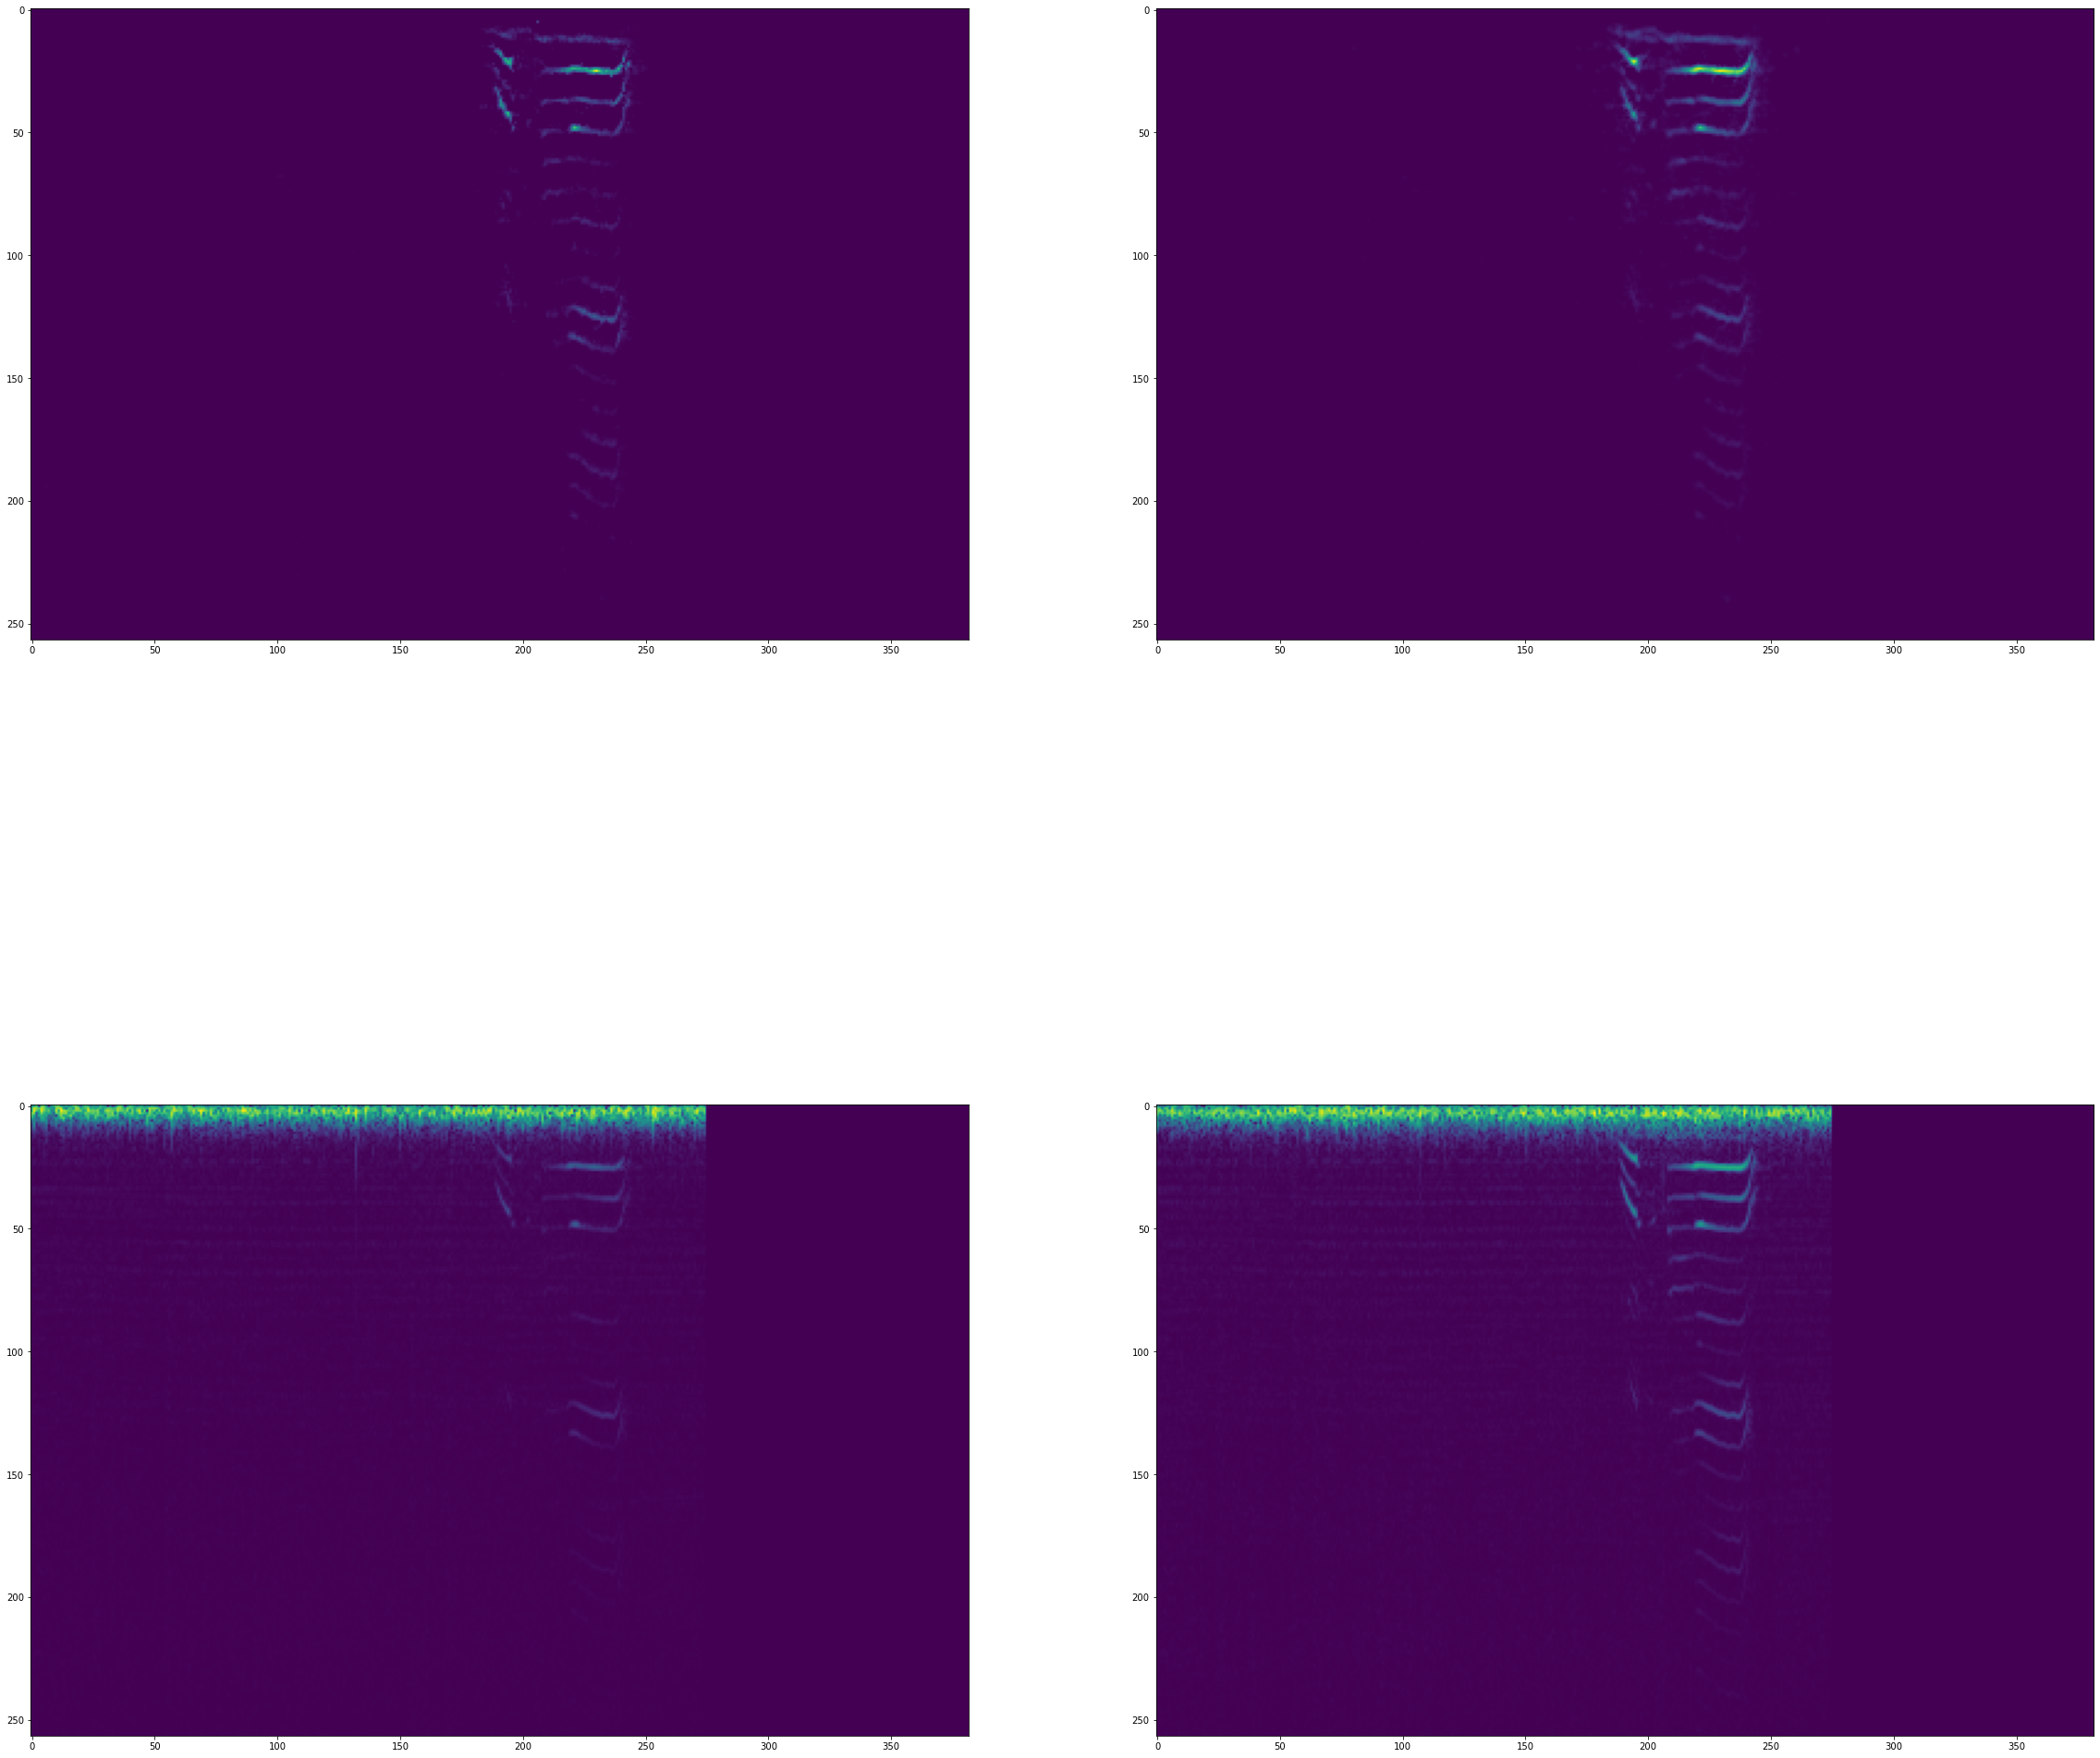

In [18]:
index = np.random.randint(0, 100)
print("Index : ", index)

fig = plt.figure(figsize=(40,40))

fig1 = fig.add_subplot(2, 2, 1)
fig1.imshow(Test[index, 1])

fig2 = fig.add_subplot(2, 2, 2)
fig2.imshow(Test[index, 0])

fig3 = fig.add_subplot(2, 2, 3)
fig3.imshow(inputs_test[index, 1])

fig4 = fig.add_subplot(2, 2, 4)
fig4.imshow(inputs_test[index, 0])

# fig5 = fig.add_subplot(4, 2, 5)
# fig5.imshow(ReConst[index, 1].numpy() - inputs_test[index, 1])

# fig6 = fig.add_subplot(4, 2, 6)
# fig6.imshow(ReConst[index, 0].numpy() - inputs_test[index, 0])

# fig7 = fig.add_subplot(4, 2, 7)
# fig7.imshow(ReConst_norm[index, 1])

# fig8 = fig.add_subplot(4, 2, 8)
# fig8.imshow(ReConst_norm[index, 0])

plt.show()